In [1]:
import gym
import numpy as np
from collections import deque
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
env = gym.make("CartPole-v1")


In [3]:
print("Understanding the Environment")
print("\n")
print("Action Space: ",env.action_space)
print("State Space: ",env.observation_space)
print("State Example: ",env.reset())
print("Cycle tuple Example: ",env.step(0))

Understanding the Environment


Action Space:  Discrete(2)
State Space:  Box(4,)
State Example:  [-0.00966349 -0.02100392  0.0063851   0.04962914]
Cycle tuple Example:  (array([-0.01008357, -0.21621684,  0.00737768,  0.34431976]), 1.0, False, {})


Bellman Equation:

The expected reward for being in a particular state s and following action prescribed by some policy is eqaul:

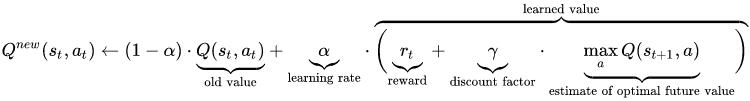

In [4]:
class My_DQN_Agent():
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen=2000)
        
        self.e = 1.000
        self.e_decay = 0.996
        self.e_min = 0.001
        
        self.learning_rate = 0.0005
        self.discount_rate = 0.995
        
        self.model = self.build_model()
        
    def build_model(self):
        
        model = Sequential()
        
        model.add(Dense(20, input_dim=self.state_size, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        
        model.compile(loss = "mse", optimizer = Adam(lr=self.learning_rate))
        
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def select_action(self, state):
        # Pick random Action if rand less than epsilon
        if np.random.rand() <= self.e:
            return np.random.randint(0,self.action_size)
        
        # Otherwise, use the current best options as action
        
        all_q_values = self.model.predict(state)
        return np.argmax(all_q_values[0])
    
    def replay(self, batch_size):
        
        #This will take (batch_size) number of (self.memory) as a mini_batch
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            if done:
                # if it has terminate, reward is just the final reward.
                target = reward
            else:
                # if it has next_state, use the bellman equation to calculate the reward
                
                target = reward + self.discount_rate * np.max(self.model.predict(next_state)[0])
            
            # Now I replay this piece on memory, get the result, then adjust it
            result = self.model.predict(state)
            result[0][action] = target
            
            self.model.fit(state, result, epochs=1, verbose=0)
        
        if self.e > self.e_min:
            self.e *= self.e_decay
    
    def load(self, name):
        self.model.load_weights(name)
    
    def save(self, name):
        self.model.save_weights(name)
        
    
        
            

In [5]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = My_DQN_Agent(state_size,action_size)
output_dir = "Project_Deep_Q_Network_model_output/cart-pole_v1"


done = False
n_episodes = 1000
batch_size = 40

score_list = []
time_list = []

for ep in range(n_episodes):
    
    state = env.reset()
    state = state.reshape(1,state_size)
    total_reward = 0
    # This is a continous game, it can go forever, so limit it in 5000 time step.
    for time_steps in range(5000): 
        
        action = agent.select_action(state)
        next_state, reward, done, _= env.step(action)
        
        reward = reward if not done else -20

        next_state = next_state.reshape(1,state_size)
        
        agent.remember(state, action, reward, next_state, done)
        
        total_reward += reward
        state = next_state
        
        if done:
            # Since we want to see how long can the agent sustain in the game. Time Step is a good measurement.
            print("Episode: {}/{} | epsilon = {:0.2f} | score = {} | Total Reward = {}".format(ep, n_episodes, agent.e, time_steps, total_reward))
            score_list.append(time_steps)
            time_list.append(ep)
            break
        
        if len(agent.memory) > batch_size:
            #if len(agent.memory) > 500:
            #    agent.memory = agent.memory[-500:-1]
            agent.replay(batch_size)
        

        if ep % 50 == 0:
            agent.save(output_dir + "_weights_" + '{:04d}'.format(ep) + ".hdf5")


Episode: 0/1000 | epsilon = 1.00 | score = 11 | Total Reward = -9.0
Episode: 1/1000 | epsilon = 1.00 | score = 21 | Total Reward = 1.0
Episode: 2/1000 | epsilon = 0.91 | score = 30 | Total Reward = 10.0
Episode: 3/1000 | epsilon = 0.85 | score = 18 | Total Reward = -2.0
Episode: 4/1000 | epsilon = 0.76 | score = 25 | Total Reward = 5.0
Episode: 5/1000 | epsilon = 0.67 | score = 33 | Total Reward = 13.0
Episode: 6/1000 | epsilon = 0.60 | score = 28 | Total Reward = 8.0
Episode: 7/1000 | epsilon = 0.48 | score = 54 | Total Reward = 34.0
Episode: 8/1000 | epsilon = 0.44 | score = 25 | Total Reward = 5.0
Episode: 9/1000 | epsilon = 0.40 | score = 21 | Total Reward = 1.0
Episode: 10/1000 | epsilon = 0.37 | score = 19 | Total Reward = -1.0
Episode: 11/1000 | epsilon = 0.31 | score = 42 | Total Reward = 22.0
Episode: 12/1000 | epsilon = 0.27 | score = 34 | Total Reward = 14.0
Episode: 13/1000 | epsilon = 0.24 | score = 30 | Total Reward = 10.0
Episode: 14/1000 | epsilon = 0.21 | score = 36 | 

Episode: 119/1000 | epsilon = 0.00 | score = 8 | Total Reward = -12.0
Episode: 120/1000 | epsilon = 0.00 | score = 9 | Total Reward = -11.0
Episode: 121/1000 | epsilon = 0.00 | score = 8 | Total Reward = -12.0
Episode: 122/1000 | epsilon = 0.00 | score = 9 | Total Reward = -11.0
Episode: 123/1000 | epsilon = 0.00 | score = 8 | Total Reward = -12.0
Episode: 124/1000 | epsilon = 0.00 | score = 11 | Total Reward = -9.0
Episode: 125/1000 | epsilon = 0.00 | score = 14 | Total Reward = -6.0
Episode: 126/1000 | epsilon = 0.00 | score = 21 | Total Reward = 1.0
Episode: 127/1000 | epsilon = 0.00 | score = 16 | Total Reward = -4.0
Episode: 128/1000 | epsilon = 0.00 | score = 24 | Total Reward = 4.0
Episode: 129/1000 | epsilon = 0.00 | score = 40 | Total Reward = 20.0
Episode: 130/1000 | epsilon = 0.00 | score = 56 | Total Reward = 36.0
Episode: 131/1000 | epsilon = 0.00 | score = 463 | Total Reward = 443.0
Episode: 132/1000 | epsilon = 0.00 | score = 195 | Total Reward = 175.0
Episode: 133/1000 

Episode: 235/1000 | epsilon = 0.00 | score = 10 | Total Reward = -10.0
Episode: 236/1000 | epsilon = 0.00 | score = 11 | Total Reward = -9.0
Episode: 237/1000 | epsilon = 0.00 | score = 12 | Total Reward = -8.0
Episode: 238/1000 | epsilon = 0.00 | score = 11 | Total Reward = -9.0
Episode: 239/1000 | epsilon = 0.00 | score = 12 | Total Reward = -8.0
Episode: 240/1000 | epsilon = 0.00 | score = 13 | Total Reward = -7.0
Episode: 241/1000 | epsilon = 0.00 | score = 12 | Total Reward = -8.0
Episode: 242/1000 | epsilon = 0.00 | score = 11 | Total Reward = -9.0
Episode: 243/1000 | epsilon = 0.00 | score = 16 | Total Reward = -4.0
Episode: 244/1000 | epsilon = 0.00 | score = 131 | Total Reward = 111.0
Episode: 245/1000 | epsilon = 0.00 | score = 499 | Total Reward = 479.0
Episode: 246/1000 | epsilon = 0.00 | score = 499 | Total Reward = 479.0
Episode: 247/1000 | epsilon = 0.00 | score = 447 | Total Reward = 427.0
Episode: 248/1000 | epsilon = 0.00 | score = 198 | Total Reward = 178.0
Episode: 

KeyboardInterrupt: 

In [6]:
len(score_list)

251

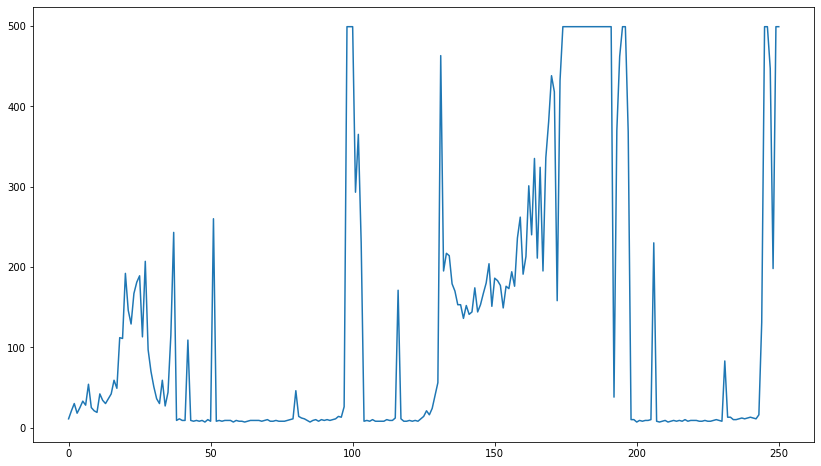

In [7]:
plt.figure(figsize=(14,8))
plt.plot(score_list)